In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
# torch.cuda.empty_cache()

tmp1=[]
tmp2=[]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array):

    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 63.0 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 60.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import sys
import string 
import re

#### text preprocessing
def text_preprocessing(tweet):
  tweet = re.sub('([@A-Za-z0-9]+)', '', tweet)

  tweet = re.sub('_|ـ', ' ', tweet)

  tweet = re.sub(r'(.)\1\1+', r'\1', tweet)
#  //normalization        
  tweet = re.sub("[إأٱآا]", "ا", tweet)
  tweet = re.sub("ة", "ه", tweet)
  tweet = re.sub("ى", "ي", tweet)
  tweet = re.sub("ؤ", "ء", tweet)
  tweet = re.sub("ئ", "ء", tweet)
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))
  return tweet 

#### bert preprocessing
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=250
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,
            truncation =True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
MARBERT_model = AutoModel.from_pretrained("UBC-NLP/MARBERT") 

# Bert-Classfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("UBC-NLP/MARBERT")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits
# Bert-Bilstm-Classfier class
class BertBilstmClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False ):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set False to fine-tune the BERT model
        """
        super(BertBilstmClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("UBC-NLP/MARBERT")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(2*H, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        self.bilstm = nn.LSTM(D_in, H, batch_first = False, bidirectional=True)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        

        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        a = outputs[0].tolist()
        #print("size out of bert:", np.array(a).shape)

        output =  self.bilstm(outputs[0])
        #print("output of BiLSTM ",len(list(outputs[0])))
         # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler
def initialize_modelB(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertBilstmClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler    

In [ ]:
import random
import time
from sklearn.metrics import f1_score

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    cm = False
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}  | {'Val Acc':^9} |{'neg F1':^9} |{'pos F1':^9} |{'micro F1':^9} |{'macro F1':^9} |{'Elapsed':^9}")
        print("-"*70)
        if(epoch_i==1):
          cm = True

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy ,val_neg_f1, val_pos_f1, microF1= evaluate(model, val_dataloader,cm)
            macroF1= (val_neg_f1+ val_pos_f1)/2
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9f} | {val_neg_f1:^9f} |{val_pos_f1:^9f} |{microF1:^9f} |{macroF1:^9f} |{time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return val_loss, val_accuracy ,val_neg_f1, val_pos_f1, microF1, macroF1


def evaluate(model, val_dataloader,cm):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    val_accuracy = []
    val_loss = []
    val_tp=[]
    val_fp=[]
    val_tn=[]
    val_fn=[]
    # tmp1=[]
    # tmp2=[]
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        t1=b_labels
        t2=preds
        if(cm):
          tmp1.extend(t1.cpu().numpy().astype(int))
          tmp2.extend(t2.cpu().numpy().astype(int))

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
        val_tp.append((((preds+1)/(b_labels+1)) == b_labels).cpu().numpy().sum())
        val_fp.append((preds - b_labels == 1).cpu().numpy().sum())
        val_tn.append((((preds+1)/(b_labels+1)) == b_labels+1).cpu().numpy().sum())
        val_fn.append((preds - b_labels == -1).cpu().numpy().sum())
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    val_tp=np.sum(val_tp)
    val_fp=np.sum(val_fp)
    val_tn=np.sum(val_tn)
    val_fn=np.sum(val_fn)
    pos= val_fn + val_tp
    neg = val_fp +val_tn
    total = pos + neg
    # print("test micro ",f1_score(tmp1,tmp2,labels=[1,0],average=None))
    print(pos, "  ", neg, "  ", total)
    val_neg_f1=(2*val_tn)/( val_tn + val_fn +neg)
    val_pos_f1=(2*val_tp)/( val_tp + val_fp +pos)
    microF1 = (val_neg_f1 * neg + val_pos_f1 * pos)/ total
    return val_loss, val_accuracy ,val_neg_f1, val_pos_f1, microF1

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

      #Loading data
data = pd.read_csv('finalDataset2.csv')
#data['finalLabel'] = data['finalLabel'].replace([-1],0)

X = data.tweet.values
#y = data.finalLabel.values
y = data.Label.values
y=y.astype(int)
### converting labels to tensors and intilizing batches
labels = torch.tensor(y)
MAX_LEN = 250
print('Tokenizing data...')
inputs, masks = preprocessing_for_bert(X)
acc_per_fold=[]
loss_per_fold=[]
neg_f1_per_fold=[]
pos_f1_per_fold=[]
micro_f1_per_fold=[]
macro_f1_per_fold=[]
noFold = 0

for train_index , val_index in KFold(n_splits=10, random_state=None, shuffle=True).split(X): 
  train_inputs = inputs[train_index]
  train_masks = masks[train_index]
  train_labels = labels[train_index]
  val_inputs = inputs[val_index]
  val_masks = masks[val_index]
  val_labels = labels[val_index]
  noFold = noFold + 1
      
  print(f"--------------------------------{noFold}-------------------------------------")      

      #splitting Data
# X_train, X_val, y_train, y_val =\
#     train_test_split(X, y, test_size=0.1, random_state=2020)
#       #Tokenizing

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 32

  # Create the DataLoader for our training set
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set
  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
  val_loss, val_accuracy ,val_neg_f1, val_pos_f1, microF1, macroF1 = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
  acc_per_fold.append(val_accuracy)
  loss_per_fold.append(val_loss)
  neg_f1_per_fold.append(val_neg_f1)
  
  pos_f1_per_fold.append(val_pos_f1)
  micro_f1_per_fold.append(microF1)
  macro_f1_per_fold.append(macroF1)

loss = np.mean(loss_per_fold)
acc = np.mean(acc_per_fold)
negf1= np.mean(neg_f1_per_fold)
posf1 = np.mean(pos_f1_per_fold)
microf1= np.mean(micro_f1_per_fold)
macrof1 = np.mean(macro_f1_per_fold)
print(f" {'Avg Loss':^10} | {'Avg Acc':^8}  |{' avg neg F1':^8}|{'avg pos F1':^8} |{'avg micro F1':^8} |{'avg macro F1':^8} ") 
print(f" { loss:^10.6f} | {acc:^9f} | {negf1:^9f} |{posf1:^9f} |{microf1:^9f} |{macrof1:^9f} ")

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


--------------------------------1-------------------------------------


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a f

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.413280   |     -      |     -     |   15.59  
   1    |   40    |   0.096377   |     -      |     -     |   14.72  
   1    |   60    |   0.120602   |     -      |     -     |   14.72  
   1    |   80    |   0.111057   |     -      |     -     |   14.80  
   1    |   100   |   0.091708   |     -      |     -     |   14.71  
   1    |   120   |   0.092334   |     -      |     -     |   14.73  
   1    |   140   |   0.054023   |     -      |     -     |   14.74  
   1    |   160   |   0.099766   |     -      |     -     |   14.83  
   1    |   180   |   0.099981   |     -      |     -     |   14.71  
   1    |   200   |   0.078996   |     -      |     -     |   14.74  
   1    |   220   |   0.096258   |     -      |     -     |   14.70  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.389620   |     -      |     -     |   15.46  
   1    |   40    |   0.136798   |     -      |     -     |   14.72  
   1    |   60    |   0.077940   |     -      |     -     |   14.70  
   1    |   80    |   0.149941   |     -      |     -     |   14.72  
   1    |   100   |   0.084214   |     -      |     -     |   14.70  
   1    |   120   |   0.110976   |     -      |     -     |   14.73  
   1    |   140   |   0.095640   |     -      |     -     |   14.71  
   1    |   160   |   0.064030   |     -      |     -     |   14.73  
   1    |   180   |   0.094714   |     -      |     -     |   14.72  
   1    |   200   |   0.066147   |     -      |     -     |   14.73  
   1    |   220   |   0.057360   |     -      |     -     |   14.72  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.404204   |     -      |     -     |   15.47  
   1    |   40    |   0.125396   |     -      |     -     |   14.72  
   1    |   60    |   0.107342   |     -      |     -     |   14.72  
   1    |   80    |   0.103200   |     -      |     -     |   14.73  
   1    |   100   |   0.046032   |     -      |     -     |   14.75  
   1    |   120   |   0.082275   |     -      |     -     |   14.74  
   1    |   140   |   0.108937   |     -      |     -     |   14.71  
   1    |   160   |   0.117089   |     -      |     -     |   14.71  
   1    |   180   |   0.062906   |     -      |     -     |   14.72  
   1    |   200   |   0.113835   |     -      |     -     |   14.73  
   1    |   220   |   0.079290   |     -      |     -     |   14.72  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.388813   |     -      |     -     |   15.46  
   1    |   40    |   0.148580   |     -      |     -     |   14.72  
   1    |   60    |   0.140885   |     -      |     -     |   14.72  
   1    |   80    |   0.122290   |     -      |     -     |   14.71  
   1    |   100   |   0.106908   |     -      |     -     |   14.73  
   1    |   120   |   0.074235   |     -      |     -     |   14.73  
   1    |   140   |   0.094213   |     -      |     -     |   14.71  
   1    |   160   |   0.070092   |     -      |     -     |   14.71  
   1    |   180   |   0.081261   |     -      |     -     |   14.72  
   1    |   200   |   0.044431   |     -      |     -     |   14.73  
   1    |   220   |   0.056145   |     -      |     -     |   14.73  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.382422   |     -      |     -     |   15.47  
   1    |   40    |   0.148598   |     -      |     -     |   14.72  
   1    |   60    |   0.107499   |     -      |     -     |   14.73  
   1    |   80    |   0.101282   |     -      |     -     |   14.72  
   1    |   100   |   0.145420   |     -      |     -     |   14.75  
   1    |   120   |   0.081204   |     -      |     -     |   14.73  
   1    |   140   |   0.143439   |     -      |     -     |   14.73  
   1    |   160   |   0.090790   |     -      |     -     |   14.72  
   1    |   180   |   0.068798   |     -      |     -     |   14.73  
   1    |   200   |   0.067913   |     -      |     -     |   14.73  
   1    |   220   |   0.090864   |     -      |     -     |   14.71  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.372033   |     -      |     -     |   15.46  
   1    |   40    |   0.160480   |     -      |     -     |   14.73  
   1    |   60    |   0.131927   |     -      |     -     |   14.73  
   1    |   80    |   0.090012   |     -      |     -     |   14.74  
   1    |   100   |   0.106762   |     -      |     -     |   14.75  
   1    |   120   |   0.074537   |     -      |     -     |   14.74  
   1    |   140   |   0.058737   |     -      |     -     |   14.74  
   1    |   160   |   0.126155   |     -      |     -     |   14.73  
   1    |   180   |   0.065838   |     -      |     -     |   14.73  
   1    |   200   |   0.099047   |     -      |     -     |   14.71  
   1    |   220   |   0.069971   |     -      |     -     |   14.74  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.391544   |     -      |     -     |   15.48  
   1    |   40    |   0.131548   |     -      |     -     |   14.74  
   1    |   60    |   0.131906   |     -      |     -     |   14.72  
   1    |   80    |   0.081462   |     -      |     -     |   14.72  
   1    |   100   |   0.109372   |     -      |     -     |   14.71  
   1    |   120   |   0.070356   |     -      |     -     |   14.72  
   1    |   140   |   0.075756   |     -      |     -     |   14.73  
   1    |   160   |   0.097755   |     -      |     -     |   14.73  
   1    |   180   |   0.113813   |     -      |     -     |   14.72  
   1    |   200   |   0.081393   |     -      |     -     |   14.75  
   1    |   220   |   0.066014   |     -      |     -     |   14.73  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.404053   |     -      |     -     |   15.48  
   1    |   40    |   0.147912   |     -      |     -     |   14.74  
   1    |   60    |   0.095635   |     -      |     -     |   14.72  
   1    |   80    |   0.154962   |     -      |     -     |   14.73  
   1    |   100   |   0.086963   |     -      |     -     |   14.74  
   1    |   120   |   0.061171   |     -      |     -     |   14.74  
   1    |   140   |   0.053215   |     -      |     -     |   14.73  
   1    |   160   |   0.065638   |     -      |     -     |   14.73  
   1    |   180   |   0.085355   |     -      |     -     |   14.72  
   1    |   200   |   0.086907   |     -      |     -     |   14.76  
   1    |   220   |   0.115631   |     -      |     -     |   14.72  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.408716   |     -      |     -     |   15.47  
   1    |   40    |   0.131568   |     -      |     -     |   14.75  
   1    |   60    |   0.177763   |     -      |     -     |   14.75  
   1    |   80    |   0.097148   |     -      |     -     |   14.74  
   1    |   100   |   0.110350   |     -      |     -     |   14.74  
   1    |   120   |   0.191093   |     -      |     -     |   14.76  
   1    |   140   |   0.086627   |     -      |     -     |   14.75  
   1    |   160   |   0.095086   |     -      |     -     |   14.74  
   1    |   180   |   0.092212   |     -      |     -     |   14.75  
   1    |   200   |   0.080576   |     -      |     -     |   14.75  
   1    |   220   |   0.072334   |     -      |     -     |   14.74  
   1    |   24

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc   |  Val Acc  | neg F1   | pos F1   |micro F1  |macro F1  | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.419950   |     -      |     -     |   15.51  
   1    |   40    |   0.120730   |     -      |     -     |   14.77  
   1    |   60    |   0.079612   |     -      |     -     |   14.77  
   1    |   80    |   0.083515   |     -      |     -     |   14.77  
   1    |   100   |   0.101459   |     -      |     -     |   14.74  
   1    |   120   |   0.130588   |     -      |     -     |   14.76  
   1    |   140   |   0.121487   |     -      |     -     |   14.75  
   1    |   160   |   0.123085   |     -      |     -     |   14.74  
   1    |   180   |   0.083431   |     -      |     -     |   14.77  
   1    |   200   |   0.079521   |     -      |     -     |   14.76  
   1    |   220   |   0.060289   |     -      |     -     |   14.76  
   1    |   24

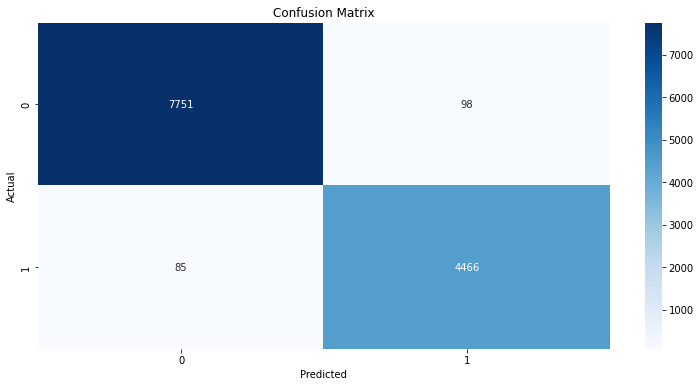

In [ ]:
plot_confusion_matrix(tmp1,tmp2)